<a href="https://colab.research.google.com/github/srishanthan/mlops/blob/main/miniproject_src.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nibabel


In [ ]:
pip install tensorflow


In [ ]:
import os
import zipfile
import shutil
import random
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
import hashlib
import datetime

# === Blockchain Classes ===
class Block:
    def __init__(self, index, data, prev_hash):
        self.timestamp = datetime.datetime.utcnow()
        self.index = index
        self.data = data
        self.prev_hash = prev_hash
        self.hash = self.compute_hash()

    def compute_hash(self):
        block_string = f"{self.index}{self.timestamp}{self.data}{self.prev_hash}"
        return hashlib.sha256(block_string.encode()).hexdigest()

class Blockchain:
    def __init__(self):
        self.chain = []
        self.create_genesis()

    def create_genesis(self):
        genesis_block = Block(0, "Genesis Block", "0")
        self.chain.append(genesis_block)

    def add_block(self, data):
        prev_hash = self.chain[-1].hash
        block = Block(len(self.chain), data, prev_hash)
        self.chain.append(block)

    def print_chain(self):
        for block in self.chain:
            print(f"Block {block.index} | Hash: {block.hash[:10]}... | Prev: {block.prev_hash[:10]}... | Data: {block.data}")

# === STEP 1: Upload and Extract ===
print("📤 Upload the bts.zip (Kaggle Brain Tumor Dataset)...")
uploaded = files.upload()

zip_path = next(iter(uploaded))
extract_path = "/content/bts_data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted folders:", os.listdir(extract_path))

# ✅ Corrected dataset path
train_path = os.path.join(extract_path, "Training")
test_path = os.path.join(extract_path, "Testing")

# === STEP 2: Simulate Non-IID Federated Clients ===
NUM_CLIENTS = 3
client_dirs = [f"/content/client_{i+1}" for i in range(NUM_CLIENTS)]

class_assignments = {
    "glioma_tumor": [0],
    "meningioma_tumor": [0],
    "pituitary_tumor": [1],
    "no_tumor": [2]
}

for client_dir in client_dirs:
    os.makedirs(client_dir, exist_ok=True)
    for cls in os.listdir(train_path):
        os.makedirs(os.path.join(client_dir, cls), exist_ok=True)

for cls in os.listdir(train_path):
    cls_path = os.path.join(train_path, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)
    clients = class_assignments.get(cls, list(range(NUM_CLIENTS)))
    split_size = len(images) // len(clients) if clients else 0

    for i, client_idx in enumerate(clients):
        start = i * split_size
        end = (i + 1) * split_size if i < len(clients) - 1 else len(images)
        for img in images[start:end]:
            src = os.path.join(cls_path, img)
            dst = os.path.join(client_dirs[client_idx], cls, img)
            shutil.copy(src, dst)

# Optional: Print image count per client
for client_dir in client_dirs:
    total_imgs = sum([len(files) for _, _, files in os.walk(client_dir)])
    print(f"{client_dir} contains {total_imgs} images")

# === STEP 3: Define Stronger CNN Model (MobileNetV2) ===
def get_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# === STEP 4: Asynchronous Federated Training with Blockchain Logging ===
ledger = Blockchain()

def async_federated_train(global_model, client_dirs, round_num, epochs=1):
    for i, client_dir in enumerate(client_dirs):
        datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

        train_data = datagen.flow_from_directory(
            client_dir,
            target_size=(224, 224),
            class_mode='categorical',
            batch_size=16,
            shuffle=True,
            subset='training'
        )
        val_data = datagen.flow_from_directory(
            client_dir,
            target_size=(224, 224),
            class_mode='categorical',
            batch_size=16,
            shuffle=True,
            subset='validation'
        )

        if train_data.samples == 0 or val_data.samples == 0:
            print(f"⚠️ Skipping client {i+1} in Round {round_num+1} due to no data.")
            continue

        local_model = tf.keras.models.clone_model(global_model)
        local_model.set_weights(global_model.get_weights())
        local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        local_model.fit(train_data, validation_data=val_data, epochs=epochs, verbose=1)

        updated_weights = local_model.get_weights()
        current_weights = global_model.get_weights()
        new_weights = [(cw + uw) / 2 for cw, uw in zip(current_weights, updated_weights)]
        global_model.set_weights(new_weights)

        ledger.add_block(f"Client {i+1} async update in Round {round_num+1}")

    return global_model

# === STEP 5: Federated Rounds ===
global_model = get_model()
for round_num in range(3):
    global_model = async_federated_train(global_model, client_dirs, round_num, epochs=1)
    print(f"✅ Federated Round {round_num+1} complete.")

# Print Blockchain Ledger
print("\n🧾 Blockchain Ledger:")



📤 Upload the bts.zip (Kaggle Brain Tumor Dataset)...


Saving Brain tumor MRI Dataset.zip to Brain tumor MRI Dataset.zip
Extracted folders: ['Training', 'Testing']
/content/client_1 contains 1902 images
/content/client_2 contains 1902 images
/content/client_3 contains 1908 images
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 1522 images belonging to 4 classes.
Found 380 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 70s 674ms/step - accuracy: 0.6734 - loss: 0.8474 - val_accuracy: 0.7368 - val_loss: 0.7156
Found 1522 images belonging to 4 classes.
Found 380 images belonging to 4 classes.
96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 730ms/step - accuracy: 0.8136 - loss: 0.5071 - val_accuracy: 0.7789 - val_loss: 0.5842
Found 1528 images belonging to 4 classes.
Found 380 images belonging to 4 classes.
96/96 ━━━━━━━━━━━━━━━━━━━━ 70s 678ms/step - accuracy: 0.8410 - loss: 0.4385 - val_accuracy: 0.7684 - val_loss: 0.6106
✅ Federated Round 1 complete.
Found 1522 images belonging to 4 classes.
Found 380 images belonging to 4 classes.
96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 722ms/step - accuracy: 0.8787 - loss: 0.3561 - val_accuracy: 0.7868 - val_loss: 0.5884
Found 1522 images belonging to 4 classes.
Found 380 images belonging to 4 classes.
96/96 ━━━━━━━━━━━━━━━━━━━━ 71s 679ms/step - accuracy: 0.8888 - loss: 0.3002 - val_accuracy: 0.7921 - val_loss: 0.5636
Found 1528 images belonging to 4 classes.
Found 

Found 1311 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 552ms/step
📄 Classification Report:
              precision    recall  f1-score      support
glioma         0.850000  0.850000  0.850000   300.000000
meningioma     0.787500  0.617647  0.692308   306.000000
notumor        0.888889  0.967901  0.926714   405.000000
pituitary      0.881818  0.970000  0.923810   300.000000
accuracy       0.859649  0.859649  0.859649     0.859649
macro avg      0.852052  0.851387  0.848208  1311.000000
weighted avg   0.854707  0.859649  0.853782  1311.000000

🔍 Overall Test Accuracy: 85.96%


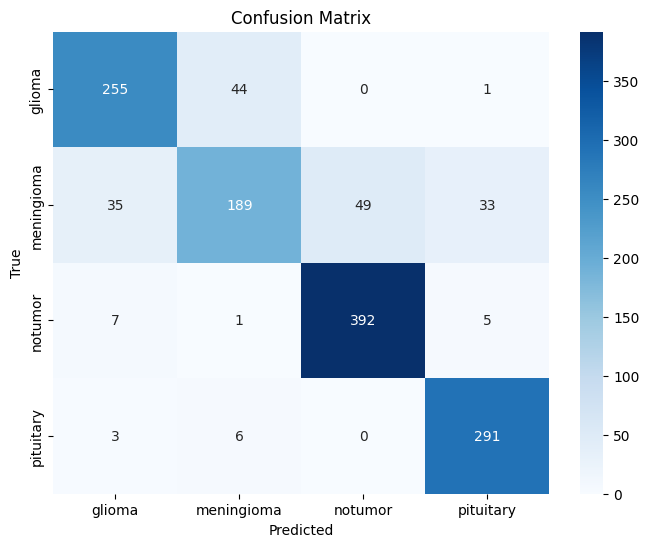

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
import numpy as np

# === Load Test Data ===
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data = datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

# === Predict ===
y_pred = global_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# === Classification Report ===
report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("📄 Classification Report:")
print(df_report)

# === Accuracy Score ===
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"\n🔍 Overall Test Accuracy: {accuracy * 100:.2f}%")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


📤 Upload bts.zip dataset


Saving Brain tumor MRI Dataset.zip to Brain tumor MRI Dataset.zip
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 1522 images belonging to 4 classes.
Found 380 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.6328 - loss: 0.8762 - val_accuracy: 0.3079 - val_loss: 3.4420 - learning_rate: 1.0000e-04
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.8833 - loss: 0.3222 - val_accuracy: 0.3763 - val_loss: 3.5058 - learning_rate: 1.0000e-04
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.9351 - loss: 0.1884 - val_accuracy: 0.4553 - val_loss: 3.3801 - learning_rate: 1.0000e-04
Found 1522 images belonging to 4 classes.
Found 380 images belonging to 4 classes.
Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - accuracy: 0.8562 - loss: 0.4387 - val_accuracy: 0.4000 - val_loss: 2.4226 - learning_rate: 1.0000e-04
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.9172 - loss: 0.2292 - val_accuracy: 0.4658 - val_loss: 2.0888 - learning_rate: 1.0000e-04
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - accuracy: 0.9250 - loss: 0.2096 - val_accuracy: 0.5447 - val_loss: 1.4725 - learning_rate: 1.00

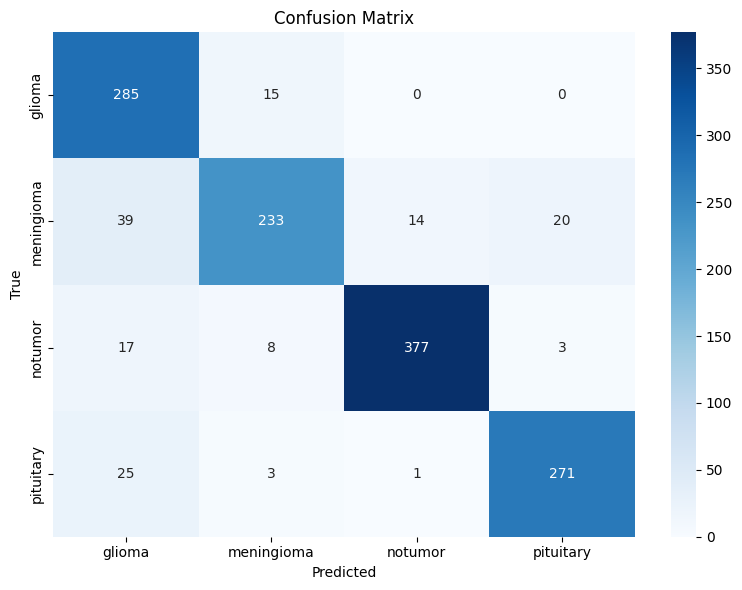


🔍 Final Test Accuracy: 88.94%

📄 Classification Report:
              precision    recall  f1-score      support
glioma         0.778689  0.950000  0.855856   300.000000
meningioma     0.899614  0.761438  0.824779   306.000000
notumor        0.961735  0.930864  0.946048   405.000000
pituitary      0.921769  0.903333  0.912458   300.000000
accuracy       0.889397  0.889397  0.889397     0.889397
macro avg      0.890451  0.886409  0.884785  1311.000000
weighted avg   0.896203  0.889397  0.889417  1311.000000

📜 Blockchain Ledger:
Block 0 | Hash: 1db50eef45... | Prev: 0... | Data: Genesis Block
Block 1 | Hash: bfb724a95f... | Prev: 1db50eef45... | Data: Client 1 async update in Round 1
Block 2 | Hash: 6a77d609c7... | Prev: bfb724a95f... | Data: Client 2 async update in Round 1
Block 3 | Hash: 9c5fe2fd01... | Prev: 6a77d609c7... | Data: Client 3 async update in Round 1
Block 4 | Hash: ae8b8f8349... | Prev: 9c5fe2fd01... | Data: Client 1 async update in Round 2
Block 5 | Hash: 54bf02aa8c..

In [1]:
# === Full Improved Federated Learning + Blockchain + Evaluation Script ===
import os
import zipfile
import shutil
import random
import numpy as np
import hashlib
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from google.colab import files

# === Blockchain Classes ===
class Block:
    def __init__(self, index, data, prev_hash):
        self.timestamp = datetime.datetime.utcnow()
        self.index = index
        self.data = data
        self.prev_hash = prev_hash
        self.hash = self.compute_hash()

    def compute_hash(self):
        block_string = f"{self.index}{self.timestamp}{self.data}{self.prev_hash}"
        return hashlib.sha256(block_string.encode()).hexdigest()

class Blockchain:
    def __init__(self):
        self.chain = []
        self.create_genesis()

    def create_genesis(self):
        genesis_block = Block(0, "Genesis Block", "0")
        self.chain.append(genesis_block)

    def add_block(self, data):
        prev_hash = self.chain[-1].hash
        block = Block(len(self.chain), data, prev_hash)
        self.chain.append(block)

    def print_chain(self):
        for block in self.chain:
            print(f"Block {block.index} | Hash: {block.hash[:10]}... | Prev: {block.prev_hash[:10]}... | Data: {block.data}")

# === Upload and Extract Dataset ===
print("📤 Upload bts.zip dataset")
uploaded = files.upload()
zip_path = next(iter(uploaded))
extract_path = "/content/bts_data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# === Paths ===
train_path = os.path.join(extract_path, "Training")
test_path = os.path.join(extract_path, "Testing")

# === Simulate Non-IID Clients ===
NUM_CLIENTS = 3
client_dirs = [f"/content/client_{i+1}" for i in range(NUM_CLIENTS)]
class_assignments = {
    "glioma_tumor": [0],
    "meningioma_tumor": [0],
    "pituitary_tumor": [1],
    "no_tumor": [2]
}

for client_dir in client_dirs:
    os.makedirs(client_dir, exist_ok=True)
    for cls in os.listdir(train_path):
        os.makedirs(os.path.join(client_dir, cls), exist_ok=True)

for cls in os.listdir(train_path):
    cls_path = os.path.join(train_path, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)
    clients = class_assignments.get(cls, list(range(NUM_CLIENTS)))
    split_size = len(images) // len(clients) if clients else 0

    for i, client_idx in enumerate(clients):
        start = i * split_size
        end = (i + 1) * split_size if i < len(clients) - 1 else len(images)
        for img in images[start:end]:
            src = os.path.join(cls_path, img)
            dst = os.path.join(client_dirs[client_idx], cls, img)
            shutil.copy(src, dst)

# === Define Improved CNN (MobileNetV2 + Fine-tuning) ===
def get_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = True  # Fine-tune base model

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# === Federated Training with Weighted Averaging and Blockchain ===
ledger = Blockchain()

def async_federated_train(global_model, client_dirs, round_num, epochs=1):
    for i, client_dir in enumerate(client_dirs):
        datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            brightness_range=[0.8, 1.2]
        )

        train_data = datagen.flow_from_directory(
            client_dir,
            target_size=(224, 224),
            class_mode='categorical',
            batch_size=16,
            subset='training'
        )
        val_data = datagen.flow_from_directory(
            client_dir,
            target_size=(224, 224),
            class_mode='categorical',
            batch_size=16,
            subset='validation'
        )

        if train_data.samples == 0 or val_data.samples == 0:
            print(f"⚠️ Skipping client {i+1} due to insufficient data.")
            continue

        local_model = tf.keras.models.clone_model(global_model)
        local_model.set_weights(global_model.get_weights())
        local_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

        cb = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
        ]

        history = local_model.fit(train_data, validation_data=val_data, epochs=epochs, verbose=1, callbacks=cb)

        # Weighted averaging by sample count
        local_weight = train_data.samples
        global_weight = sum([train_data.samples for client_dir in client_dirs])
        alpha = local_weight / global_weight

        updated_weights = local_model.get_weights()
        current_weights = global_model.get_weights()
        new_weights = [(1 - alpha) * cw + alpha * uw for cw, uw in zip(current_weights, updated_weights)]
        global_model.set_weights(new_weights)

        ledger.add_block(f"Client {i+1} async update in Round {round_num+1}")

    return global_model

# === Training Rounds ===
global_model = get_model()
for round_num in range(3):
    global_model = async_federated_train(global_model, client_dirs, round_num, epochs=3)
    print(f"✅ Federated Round {round_num+1} complete.")

# === Evaluate on Test Set ===
datagen_test = ImageDataGenerator(rescale=1./255)
test_data = datagen_test.flow_from_directory(
    test_path,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

y_pred = global_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"\n🔍 Final Test Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("\n📄 Classification Report:")
print(report_df)

# Print blockchain ledger
print("\n📜 Blockchain Ledger:")
ledger.print_chain()
